# **MODEL TRAINING**

**Import Libraries**

In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pylab as plt
import seaborn as sns

**Install Package gdown**

In [2]:
!pip install gdown -q

**Download Dataset**

In [3]:
#Download Dataset from Google Drive
!gdown 'https://drive.google.com/uc?id=1Y_TehM7tktG06USzgEsEdkGTbwrTYFno' -O dataset.zip
#Extract Dataset
!unzip -q dataset.zip
#Move Dataset to /Content
!mv /content/content/dataset /content
#Remove /content/content
!rm -rf /content/content

Downloading...
From: https://drive.google.com/uc?id=1Y_TehM7tktG06USzgEsEdkGTbwrTYFno
To: /content/dataset.zip
100% 1.09G/1.09G [00:16<00:00, 64.9MB/s]


**Create Directories**

In [4]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/dev"
test_dir = "/content/dataset/test"

**Select Feature Vector Module**

In [5]:
#Using Mobilenet_v2 for feature Vector
handle_base="mobilenet_v2"
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

#Size of the feature vector
FV_SIZE = 1280

#Image Size in Pixels
IMAGE_SIZE = (224,224)

## **Image Data Generator**

**Image Dataset with Augmentation**


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.


**Create labels.txt file with the class names**

In [7]:
class_names = list(train_generator.class_indices.keys())

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

**Check Class Names**

In [8]:
class_names = os.listdir(train_dir)
class_names

['cup_cakes',
 'fried_rice',
 'pancakes',
 'soup',
 'cheesecake',
 'egg',
 'salad',
 'ice_cream',
 'donuts',
 'hot_dog',
 'bakso',
 'sate',
 'french_fries',
 'waffles',
 'spaghetti_bolognese',
 'rendang',
 'pizza',
 'hamburger',
 'gado',
 'churros']

## **Modelling**

**Build Model with TF Hub Module**

In [9]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable=False
)

**Build Model with the Chosen Module Handle**

In [10]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(20, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 2283604 (8.71 MB)
Trainable params: 25620 (100.08 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


**Compile the Model**

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Create Early Stopping**

In [12]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True
)

## **TRAINING**

**Fit the Model**

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
438/438 [==============================] - 888s 2s/step - loss: 0.9397 - accuracy: 0.7327 - val_loss: 0.6249 - val_accuracy: 0.8080
Epoch 2/10
438/438 [==============================] - 836s 2s/step - loss: 0.5555 - accuracy: 0.8324 - val_loss: 0.5728 - val_accuracy: 0.8163
Epoch 3/10
438/438 [==============================] - 868s 2s/step - loss: 0.4827 - accuracy: 0.8551 - val_loss: 0.5594 - val_accuracy: 0.8307
Epoch 4/10
438/438 [==============================] - 730s 2s/step - loss: 0.4365 - accuracy: 0.8649 - val_loss: 0.5563 - val_accuracy: 0.8297
Epoch 5/10
438/438 [==============================] - 764s 2s/step - loss: 0.4098 - accuracy: 0.8731 - val_loss: 0.5791 - val_accuracy: 0.8220
Epoch 6/10
438/438 [==============================] - 783s 2s/step - loss: 0.3811 - accuracy: 0.8806 - val_loss: 0.5504 - val_accuracy: 0.8387
Epoch 7/10
438/438 [==============================] - 737s 2s/step - loss: 0.3563 - accuracy: 0.8871 - val_loss: 0.5744 - val_accuracy: 0.8267

## **RESULT**

Accuracy Curve and Loss Curve

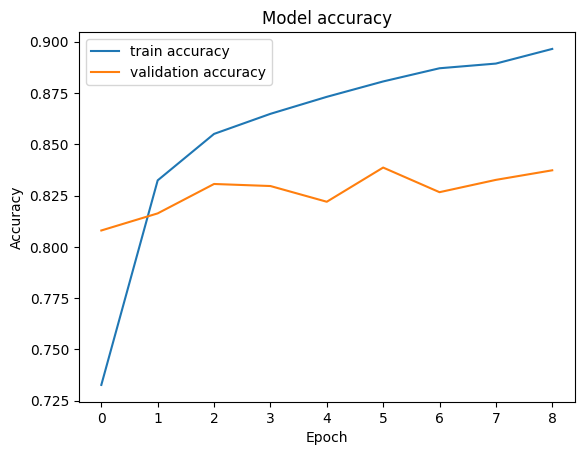

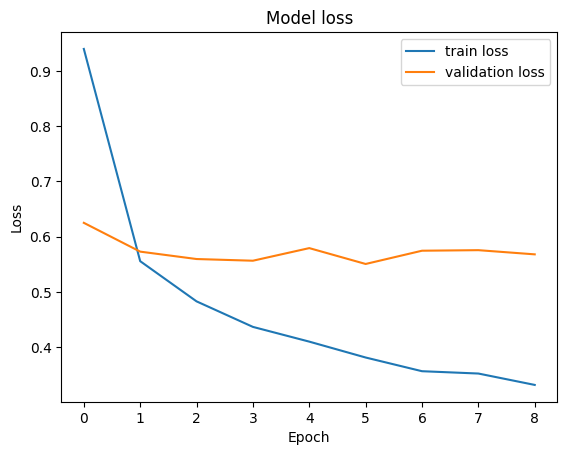

In [14]:
def plot_accuracy(history):

    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

plot_accuracy(history)
plot_loss(history)

**Model Evaluation for Validation Accuracy**

In [15]:
scores = model.evaluate(validation_generator)
print("Validation Accuracy: {:.3f}".format(scores[1]))


94/94 [==============================] - 117s 1s/step - loss: 0.5504 - accuracy: 0.8387
Validation Accuracy: 0.839


**Model Evaluation for Test Accuracy**

In [16]:
scores = model.evaluate(test_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

94/94 [==============================] - 109s 1s/step - loss: 0.4812 - accuracy: 0.8573
Test Accuracy: 0.857


**Result of Training**

In [17]:
feature_extraction_results = pd.DataFrame(history.history)
feature_extraction_results

,loss,accuracy,val_loss,val_accuracy
0,0.939724,0.732714,0.624898,0.808000
1,0.555499,0.832429,0.572760,0.816333
2,0.482730,0.855071,0.559370,0.830667
3,0.436513,0.864857,0.556313,0.829667
4,0.409839,0.873143,0.579133,0.822000
5,0.381090,0.880643,0.550418,0.838667
6,0.356291,0.887071,0.574421,0.826667
7,0.352088,0.889357,0.575413,0.832667
8,0.331468,0.896500,0.567833,0.837333


## **Image Predictions**

**Testing the Model on Testing Set**

1/1 [==============================] - 1s 636ms/step
Predicted class index: 0


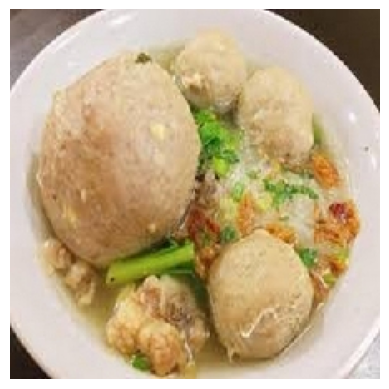

Predicted class label: bakso


In [18]:
#Specify the image path want to predict
image_path = 'dataset/test/bakso/bakso-21947.jpg'

#Read and images preprocessing
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

#Predictions
predictions = model.predict(img_array)

#Take the class index with the highest probability
predicted_class = np.argmax(predictions)

#Show prediction results
print("Predicted class index:", predicted_class)

#Mapping class indices to class labels
class_labels = ["bakso","cheesecake", "churros","cup_cakes", "donuts",
                "egg", "french_fries", "fried_rice", "gado","hamburger",
                "hot_dog", "ice_cream","pancakes", "pizza", "rendang",
                "salad","sate", "soup", "spaghetti_bolognese", "waffles"]

#Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

#Get the predicted class label
predicted_label = class_labels[predicted_class]

#Display the predicted class label
print("Predicted class label:", predicted_label)

**Classification Report**

In [19]:
#Making Predictions on Test Data
Y_pred = model.predict(test_generator)
#Taking the Class Index with the Highest Probability Value
y_pred = np.argmax(Y_pred, axis=1)
#Create Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
#Show Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

94/94 [==============================] - 104s 1s/step
Classification Report
                     precision    recall  f1-score   support

          cup_cakes       0.10      0.10      0.10       150
         fried_rice       0.05      0.06      0.06       150
           pancakes       0.01      0.01      0.01       150
               soup       0.05      0.05      0.05       150
         cheesecake       0.07      0.08      0.08       150
                egg       0.05      0.05      0.05       150
              salad       0.05      0.05      0.05       150
          ice_cream       0.04      0.05      0.04       150
             donuts       0.03      0.03      0.03       150
            hot_dog       0.06      0.06      0.06       150
              bakso       0.03      0.03      0.03       150
               sate       0.06      0.06      0.06       150
       french_fries       0.07      0.07      0.07       150
            waffles       0.06      0.05      0.06       150
spaghett

**Confusion Matrix**

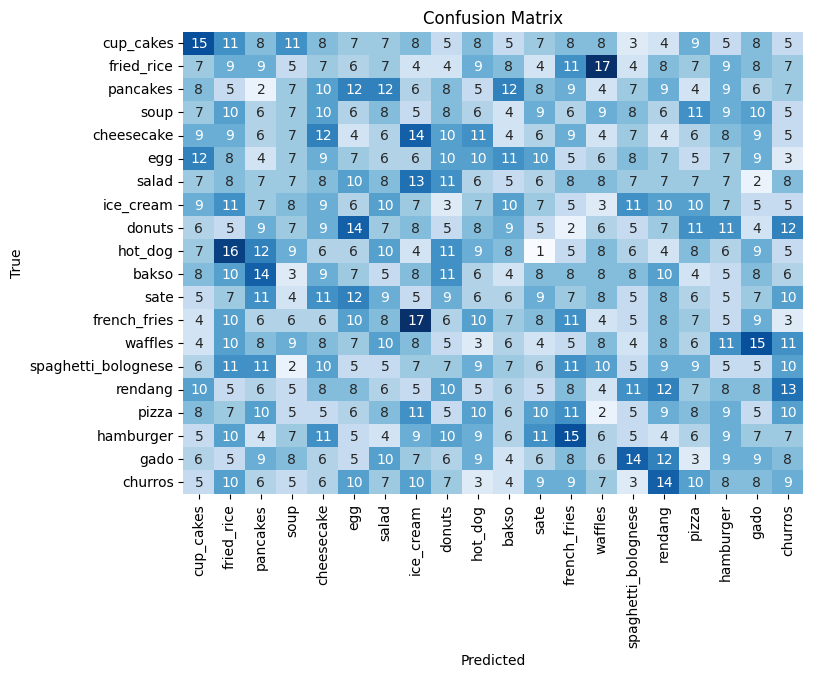

In [21]:
#Function to show the confusion matrix
def plot_confusion_matrix(cm, class_names, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#Using a previously calculated confusion matrix (cm variable)
plot_confusion_matrix(cm, class_names, figsize=(8, 6))

## **Save Model**

In [22]:
model.save('model.h5')
model.save('model')
!zip -r 'model.zip' 'model'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/fingerprint.pb (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/keras_metadata.pb (deflated 81%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 78%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)


## **Convert Model**

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model('model')

#Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

#Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2532864